In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from functions.data_functions import DataFunctions as dfc
from scipy.optimize import curve_fit
from scipy.integrate import cumulative_trapezoid
from matplotlib import animation
from matplotlib.animation import PillowWriter

plt.style.use(['science', 'no-latex', 'notebook', 'grid'])
from figures import Plot as plot

In [2]:
df = pd.read_excel('data/salt_hydrolysis_data.xlsx')
df

,Номер,температура,концентрация,соотношение,анатаз,рутил,брукит,окр_анатаз,окр_рутил,окр_брукит,агент_масса,агент_тип,пгс_объем,пгс_масса,мокрый_масса,сухой_масса,после_прокалки_%,агрегаты_размер,насыпной_вес,время_выдержки
0,70,135,21.32,0.116,18.00,44.00,38.0,8.2,24.2,17.2,-,MgCl2,-,-,-,-,-,5.62,0.596,-
1,71,135,21.32,0.402,14.00,78.00,8.0,7.5,22.2,10,-,MgCl2,-,-,-,-,-,9.95,1.068,-
2,72,135,21.32,0.200,30.00,27.00,43.0,7.3,18.8,10,-,MgCl2,-,-,-,-,-,6.58,0.68,-
3,73,135,21.32,0.490,30.30,69.70,0.0,7.3,16.2,-,-,MgCl2,-,-,-,-,-,5.96,1.096,-
4,74,125,21.32,0.255,5.66,94.34,0.0,8,23,-,-,MgCl2,-,-,-,-,-,14.3,1.02,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,148,125,15.30,0.100,20.30,72.50,7.1,7,14,11,150,MgCl2,-,-,-,-,-,-,-,90
69,149,125,15.30,0.100,22.40,59.60,18.5,7.5,17,10,150,MgCl2,-,-,-,-,-,-,-,260
70,150,125,15.30,0.100,15.60,64.00,20.3,9.5,20.3,10.3,150,MgCl2,-,-,-,-,-,-,-,-
71,152,120,15.30,0.100,23.30,48.60,28.1,7,16,11,150,CaCl2,-,-,-,-,-,-,-,-


Жернал экспериментов состоит из следующих столбцов:
+ __Номер__ - номер эксперимента
+ __температура__ - температура, при которой проводился процесс. Температура достигается путём выпаривания воды из раствора $ MgCl_{2} $
+ __концентрация__ - концентрация водного раствора хлорида титана.
+ __соотношение__ - отношение массы полученного оксида титана к массе разделяющего агента $ \frac{TiO_{2}}{MgCl_{2}} $
+ __анатаз__ - содержание фазы анатаза в полученном оксиде титана.
+ __рутил__ - содержание фазы рутила в полученном оксиде титана.
+ __брукит__ - содержание фазы брукита в полученном оксиде титана.
+ __окр_анатаз__ - размер кристаллитов фазы анатаза *ОКР (область когерентного рассеяния) рентгеновского излучения* 
+ __окр_рутил__ - размер кристаллитов фазы рутила *ОКР показывает какого размера кристаллиты фаз в нанометрах*
+ __окр_брукит__ - размер кристаллитов фазы брукита
+ __агент_масса__ - масса разделяющего агента при проведении процесса. *таже смотри соотношение*
+ __агент_тип__ - отдельные эксперименты делались для $ CaCl_{2} $, но в основном это $ MgCl_{2} $
+ __пгс_объем__ - объем сконденсированной парогазовой смеси, выделевшейся из реакционного пространства
+ __пгс_масса__ - масса сконденсированной парогазовой смеси, выделевшейся из реакционного пространства
+ __мокрый_масса__ - масса оксида титана, отфильтрованного от маточного раствора и направленного на сушку
+ __сухой_масса__ - масса оксида титана после сушки
+ __после_прокалки%__ - содержание оксида титана после сушки. Иначе, как много воды остаётся после сушки
+ __агрегаты_размер__ - кристаллиты образуют слабосвязанные агрегаты, в микрометрах
+ __насыпной_вес__ - масса 5 мл просушенного порошка
+ __время_выдержки__ - отдельные эксперименты велись при одинаковых условиях, но с разным временем выдержки в условиях процесса, после подачи материала.

In [3]:
exclude_list = ['агент_тип']
df = dfc.delete_hyphens(df, exclude_list)

## Необязательное для дальнейшего изучения работы введение в теорию.
Химическое взаимодействие вещества с водой называют реакцией гидролиза. Реакция гидролиза хлорида титана выглядит следующим образом:
$$
TiCl_{4} + 4 H_{2}O \leftrightharpoons Ti(OH)_{4} + 4 HCl~~~~(1)
$$
Эта реакция, как видно из написания, разрешена в обе стороны. Проблема для технологии состоит в том, что равновесие этой реакции слабо смещено в сторону образования продуктов. Таким образом, лучше всего реакцию описывает уравнение:
$$
TiCl_{4} + 2 H_{2}O \rightarrow TiCl_{2}(OH)_{2} + 2 HCl~~~~(2)
$$
Сильно поляризованные молекулы, такие как молекулы соляной кислоты (HCl) в воде растворяются (диссоциируют) на ионы с избытком электронной плотности(анионы) и недостатком(катионы). При образовании водных растворов электролитов происходит взаимодействие между ионами растворенного вещества и молекулами воды. Эти взаимодействия в основном и определяют свойства растворов, а результат этого взаимодействия называется гидратацией. Например, реакция гидратации соляной кислоты выглядит следующим образом:
$$
HCl(aq) \leftrightharpoons H^+(aq) + Cl^-(aq)~~~~(3)
$$
'aq' обозначает что молекула HCl и её ионы окружены молекулами воды. Как видно из написания, эта реакция разрешена в обе стороны. Природа так устроена, что независимо от того как много соляной кислоты мы поместим в раствор, отношение продуктов реакции к исходным веществам будет одинаковым. Такое отношение называется КОНСТАНТОЙ диссоциации. 
$$
K_\text{a} = \frac{[\text{H}^+][\text{Cl}^-]}{[\text{HCl}]}~~~~(4)
$$
Подчеркну ещё раз, что отношение произведения концентрации ионов ($[Cl^-]$ и $[H^+]$) к концентрации недиссоциированной кислоты $[HCl]$ в растворе величина постоянная. 
Тогда если в раствор добавить другое вещество, при растворении которого в раствор будет выделяться $Cl^-$, произведение концентраций вверху дроби вырастет и для достижения равновесия система будет стремиться к ассоциации ионов и образованию соляной кислоты $HCl$. Соляная кислота в ассоциированном состоянии газообразна и будет удаляться из реакционного пространства, этот процесс называется высаливанием. Таким образом, равновесие реакции (1) будет смещено в сторону образования продуктов реакции и гидролиз хлорида титана пройдет до конца.

Вещество, которое смещает равновесие гидролиза, называют разделяющий агент. В этой работе в качестве разделяющего агента выбран $MgCl_{2}$. Выбор разделяющего агента задача непростая и зависит от таких характеристик как растворимость, энергия гидратации иона, радиус иона и многое другое. Мы же немного углубимся в систему $MgCl_{2}–HCl–H_{2}O$. 

 Повышение концентрации $MgCl_{2}$ заметно изменяет равновесие жидкость – пар в системе $HCl–H_{2}O$, смещая азеотропный состав соляной кислоты с 20,27% (при отсутствии разделяющего агента), до нуля ( концентрации разделяющего агента 25%). Для объяснения данного факта можно воспользоваться теорией Дебая и Мак-Ойля, согласно которой солевой эффект должен быть обратно пропорционален диэлектрической проницаемости смешанного растворителя. По экспериментальным данным, представленным в работе [1], были рассчитаны единые нулевые коэффициенты активности для хлороводорода в зависимости от концентрации хлорида магния в растворе. Было обнаружено, что с увеличением массовой концентрации хлорида магния диэлектрическая проницаемость раствора тройной системы $MgCl_{2}–HCl–H_{2}O$ уменьшается с 80 (0% масс. $MgCl_{2}$) до 20 (30% масс. $MgCl_{2}$). Это приводит к тому, что хлороводород в этом растворителе приобретает свойства слабого электролита, т.е. добавление хлорида магния в соляную кислоту приводит к ассоциации протона ($H^+$) и хлор-иона ($Cl^-$) в молекулу хлороводорода.


[1] Почтарев А.Н., Кожемякин В. А. Фазовое равновесие жидкость-пар в системе MgCl2-HCl-H2O // Цветные металлы. 1977. № 4. с. 47–51.



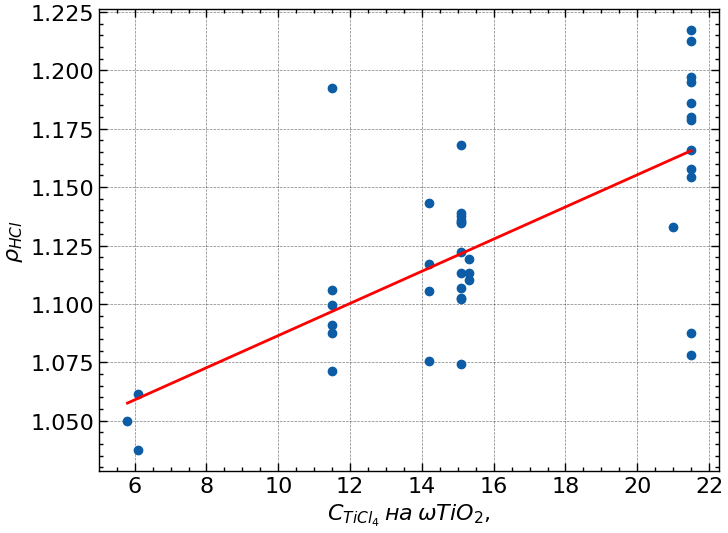

In [4]:
df['пгс_плотность'] = df['пгс_масса']/df['пгс_объем']

x = df[df['пгс_плотность'].notna()].sort_values(by='концентрация')['концентрация']
y = df[df['пгс_плотность'].notna()].sort_values(by='концентрация')['пгс_плотность']

plt.scatter(x, y)
plt.plot(x, dfc.get_fit(x,y, n=2), 'r-')

plt.xlabel('$ C_{TiCl_{4}} \: на \: \omega TiO_{2},% $')
plt.ylabel('$ \\rho_{HCl} $')
#plt.savefig('images/figure_0')
plt.show()

На рисунке сверху показана зависимость плотности сконденсированной паро-газовой смеси, удалённой из реакционного простраства, от концентрации водного раствора хлорида титана. Для того чтобы подавить интенсивность гидролиза исходный хлорид титана(а при номальных условиях это жидкость) приходилось разбавлять. Технология приготовления водного раствора хлорида титана - отдельная тема и обсуждать её не будем. Важно понимать как находилась концентрация приготовленного раствора. 

После смешения реагентов отбиралась навеска раствора. В избытке осадителя ($NH_{4}OH$) из навески выделяли оксид ($TiO_{2}$), удаляли воду и сравнивали массу полученного продукта с исходной. 

Из рисунка можно сделать вывод что чем большей концентрации мы подаём раствор хлорида титана, тем концентрированнее высаливается соляная кислота из раствора.

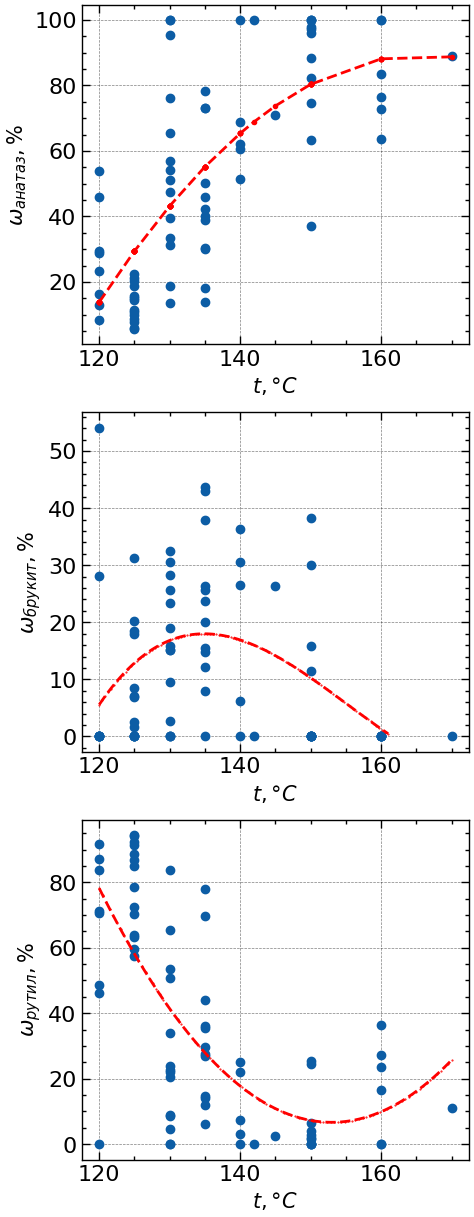

In [5]:
fig = plot.figure_1(df)
#plt.savefig('images/figure_1')

Из рисунка выше можно сделать вывод, что температура существенным образом влияет на распределение состава фаз в полученном продукте. Можно наблюдать, что в представленном интервале температур концентрация рутила имеминимум в области 150°С. Концентрация анатаза растет, а концентрация брукит проходит через максимум в области 135°С. 

In [6]:
def new_concentration(row):
     if row > 20:
          return 'высокая'
     elif row > 14:
          return 'средняя'
     elif row > 10:
          return 'малая'
     return 'минимальная'

df['область_концентраций'] = df['концентрация'].apply(new_concentration)
df[['область_концентраций', 'концентрация']].head(15)

,область_концентраций,концентрация
0,высокая,21.32
1,высокая,21.32
2,высокая,21.32
3,высокая,21.32
4,высокая,21.32
5,высокая,21.32
6,высокая,21.32
7,малая,11.48
8,малая,11.48
9,малая,11.48


Из-за сложности приготовления водного раствора хлорида титана попасть в необходимую концентрацию было трудно. Для дальнейших исследований область концентраций была разделена на 4 части.

In [7]:
def new_volume(row):
     if row>130 and row<160:
          return 'стандартный'
     elif row>60 and row<130:
          return 'малый'
     return np.nan

df['объем_реактора'] = df['агент_масса'].apply(new_volume)

volume_filter = df['объем_реактора'] == 'стандартный'

df[['объем_реактора', 'агент_масса']].head(25)

,объем_реактора,агент_масса
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


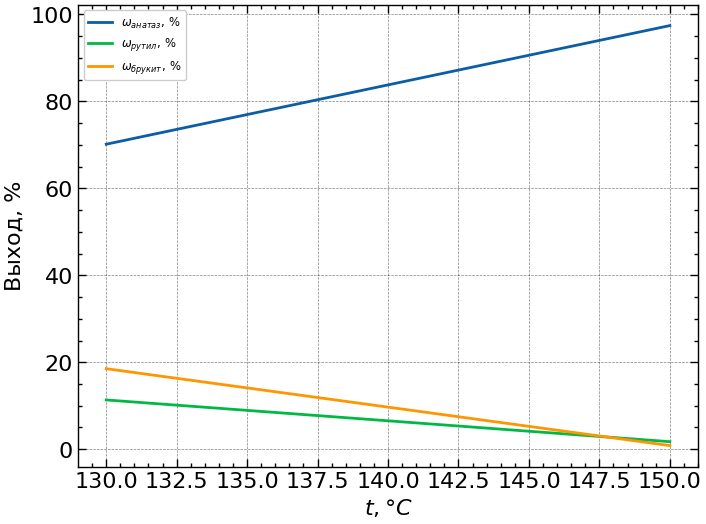

,Номер,температура,концентрация,соотношение,анатаз,рутил,брукит,окр_анатаз,окр_рутил,окр_брукит,...,пгс_масса,мокрый_масса,сухой_масса,после_прокалки_%,агрегаты_размер,насыпной_вес,время_выдержки,пгс_плотность,область_концентраций,объем_реактора
32,112,130,21.50,0.2,100.0,0.0,0.0,7.80,NaN,NaN,...,34.06,21.06,7.96,NaN,NaN,NaN,NaN,1.195088,высокая,малый
2,72,135,21.32,0.2,30.0,27.0,43.0,7.30,18.8,10.0,...,NaN,NaN,NaN,NaN,6.58,0.680,NaN,NaN,высокая,NaN
29,108,142,21.50,0.2,100.0,0.0,0.0,7.95,NaN,NaN,...,56.57,51.78,16.03,NaN,NaN,NaN,NaN,1.154490,высокая,малый
15,86,150,21.50,0.2,96.0,4.0,0.0,9.00,19.6,NaN,...,87.28,81.03,30.80,91.43,1.11,0.441,NaN,1.185870,высокая,стандартный
19,90,150,21.50,0.2,100.0,0.0,0.0,9.00,NaN,NaN,...,86.73,NaN,33.52,87.58,NaN,NaN,NaN,1.180000,высокая,стандартный
20,91,150,21.50,0.2,100.0,0.0,0.0,9.00,NaN,NaN,...,90.77,NaN,37.15,86.67,NaN,NaN,NaN,1.178831,высокая,стандартный


In [8]:
ratio_filter = (df['соотношение'] <= 0.21) & (df['соотношение'] >= 0.2)
concentration_filter = df['область_концентраций'] == 'высокая'

x = df[ratio_filter & concentration_filter].sort_values(by='температура')['температура'].values
anatase = df[ratio_filter & concentration_filter].sort_values(by='температура')['анатаз'].values
rutile = df[ratio_filter & concentration_filter].sort_values(by='температура')['рутил'].values
brukite = df[ratio_filter & concentration_filter].sort_values(by='температура')['брукит'].values

plt.plot(x,dfc.get_fit(x,anatase, n=2), label='$\omega_{анатаз},\:\%$')
plt.plot(x,dfc.get_fit(x,rutile, n=2), label='$\omega_{рутил},\:\%$')
plt.plot(x,dfc.get_fit(x,brukite, n=2), label='$\omega_{брукит},\:\%$')

plt.legend(loc='best', fontsize='small')
plt.ylabel("Выход, %")
plt.xlabel(r'$ t,°C $')
plt.show()

df[ratio_filter & concentration_filter].sort_values(by='температура')

Здесь и ниже без дополнительных комментариев приведены зависимости выхода от температуры при различных  _соотношениях_  и  _концентрациях_ . 

Аппроксимационные кривые нарочно подобраны спекулятивным образом, чтобы показать зависимость одной фазы от другой. Исходя из этой гипотезы в дальнейшем я попробую раскрыть природу протекающих процессов.

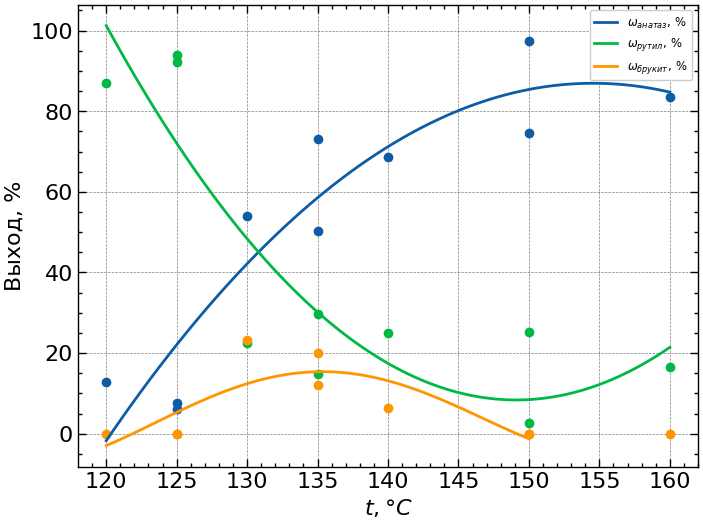

,Номер,температура,концентрация,соотношение,анатаз,рутил,брукит,окр_анатаз,окр_рутил,окр_брукит,...,пгс_масса,мокрый_масса,сухой_масса,после_прокалки_%,агрегаты_размер,насыпной_вес,время_выдержки,пгс_плотность,область_концентраций,объем_реактора
39,119,120,15.1,0.2,12.9,87.1,0.0,7.1,15.5,NaN,...,NaN,41.14,20.00,NaN,NaN,NaN,NaN,NaN,средняя,стандартный
44,124,125,15.1,0.2,7.7,92.3,0.0,9.7,18.5,NaN,...,NaN,55.74,32.55,NaN,NaN,NaN,NaN,NaN,средняя,стандартный
45,125,125,15.1,0.2,6.0,94.0,0.0,NaN,NaN,NaN,...,NaN,56.01,31.98,NaN,NaN,NaN,NaN,NaN,средняя,стандартный
40,120,130,15.1,0.2,54.1,22.6,23.3,6.9,16.1,21.5,...,168.20,56.00,29.40,NaN,NaN,NaN,NaN,1.168056,средняя,стандартный
56,136,135,15.1,0.2,50.3,29.6,20.0,7.5,16.0,12.0,...,NaN,56.51,31.70,NaN,NaN,NaN,NaN,NaN,средняя,стандартный
41,121,140,15.1,0.2,68.7,25.0,6.3,7.7,16.1,20.0,...,169.50,61.40,31.13,NaN,NaN,NaN,NaN,1.137584,средняя,стандартный
16,87,150,14.2,0.2,97.3,2.7,0.0,9.5,8.5,NaN,...,171.83,71.56,32.00,90.87,2.62,0.384,NaN,1.143247,средняя,стандартный
42,122,150,15.1,0.2,74.7,25.3,0.0,8.3,12.2,NaN,...,167.37,92.59,32.25,NaN,NaN,NaN,NaN,NaN,средняя,стандартный
43,123,160,15.1,0.2,83.5,16.5,0.0,8.0,16.1,NaN,...,NaN,85.30,39.22,NaN,NaN,NaN,NaN,NaN,средняя,стандартный


In [9]:
ratio_filter = (df['соотношение'] <= 0.21) & (df['соотношение'] >= 0.2)
concentration_filter = df['область_концентраций'] == 'средняя'
volume_filter = df['объем_реактора'] == 'стандартный'


x = df[ratio_filter & concentration_filter].sort_values(by='температура')['температура'].values
anatase = df[ratio_filter & concentration_filter].sort_values(by='температура')['анатаз'].values
rutile = df[ratio_filter & concentration_filter].sort_values(by='температура')['рутил'].values
brukite = df[ratio_filter & concentration_filter].sort_values(by='температура')['брукит'].values

x_ = np.linspace(min(x), max(x), 100)
x_brukite = np.linspace(120, 150, 100)

y_anatase = dfc.get_coeffs(x,anatase,n=3)
y_rutile = dfc.get_coeffs(x,rutile,n=3)
y_brukite = dfc.get_coeffs(x,brukite,n=5)


plt.plot(x_,np.polyval(y_anatase,x_), label='$\omega_{анатаз},\:\%$')
plt.scatter(x,anatase)
plt.plot(x_,np.polyval(y_rutile,x_), label='$\omega_{рутил},\:\%$')
plt.scatter(x,rutile)
plt.plot(x_brukite,np.polyval(y_brukite,x_brukite), label='$\omega_{брукит},\:\%$')
plt.scatter(x,brukite)

plt.legend(loc='best', fontsize='small')
plt.ylabel("Выход, %")
plt.xlabel(r'$ t,°C $')


plt.show()

df[ratio_filter & concentration_filter & volume_filter].sort_values(by='температура')

Адекватность линий тренда 1.0040052678344586


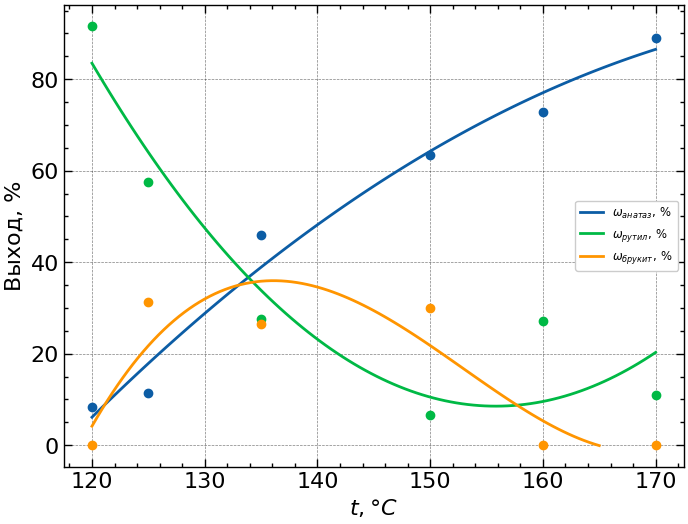

,Номер,температура,концентрация,соотношение,анатаз,рутил,брукит,окр_анатаз,окр_рутил,окр_брукит,...,пгс_масса,мокрый_масса,сухой_масса,после_прокалки_%,агрегаты_размер,насыпной_вес,время_выдержки,пгс_плотность,область_концентраций,объем_реактора
8,78,120,11.48,0.205,8.27,91.73,0.00,8.0,17.0,NaN,...,NaN,NaN,NaN,NaN,14.00,0.867,NaN,NaN,малая,NaN
7,77,125,11.48,0.205,11.30,57.51,31.19,11.0,20.0,NaN,...,NaN,NaN,NaN,NaN,7.24,0.730,NaN,NaN,малая,NaN
10,80,135,11.48,0.203,45.95,27.67,26.38,9.0,17.0,NaN,...,NaN,NaN,NaN,NaN,6.00,0.507,NaN,NaN,малая,NaN
9,79,150,11.48,0.210,63.37,6.58,30.05,8.0,20.0,NaN,...,NaN,NaN,NaN,NaN,4.00,0.441,NaN,NaN,малая,NaN
11,82,160,11.50,0.200,72.80,27.20,0.00,8.5,11.5,NaN,...,229.27,82.17,32.18,94.38,2.54,0.256,NaN,1.099616,малая,стандартный
17,88,170,11.50,0.200,89.00,11.00,0.00,8.5,11.0,NaN,...,222.88,83.50,32.50,91.70,1.19,0.214,NaN,1.106104,малая,стандартный


In [10]:
ratio_filter = (df['соотношение'] <= 0.21) & (df['соотношение'] >= 0.2)
concentration_filter = df['область_концентраций'] == 'малая'

x = df[ratio_filter & concentration_filter].sort_values(by='температура')['температура'].values
anatase = df[ratio_filter & concentration_filter].sort_values(by='температура')['анатаз'].values
rutile = df[ratio_filter & concentration_filter].sort_values(by='температура')['рутил'].values
brukite = df[ratio_filter & concentration_filter].sort_values(by='температура')['брукит'].values

x_ = np.linspace(min(x), max(x), 100)
x_brukite = np.linspace(120, 165, 100)

y_anatase = dfc.get_coeffs(x,anatase,n=3)
y_rutile = dfc.get_coeffs(x,rutile,n=3)
y_brukite = dfc.get_coeffs(x,brukite,n=5)


plt.plot(x_,np.polyval(y_anatase,x_), label='$\omega_{анатаз},\:\%$')
plt.scatter(x,anatase)
plt.plot(x_,np.polyval(y_rutile,x_), label='$\omega_{рутил},\:\%$')
plt.scatter(x,rutile)
plt.plot(x_brukite,np.polyval(y_brukite,x_brukite), label='$\omega_{брукит},\:\%$')
plt.scatter(x,brukite)

plt.legend(loc='best', fontsize='small')
plt.ylabel("Выход, %")
plt.xlabel(r'$ t,°C $')

print(f'Адекватность линий тренда {np.mean([(np.polyval(y_anatase,x)+np.polyval(y_rutile,x)+np.polyval(y_brukite,x))/100 for x in x_])}')
plt.show()
df[ratio_filter & concentration_filter].sort_values(by='температура')

Адекватность линий тренда 0.999999999984831


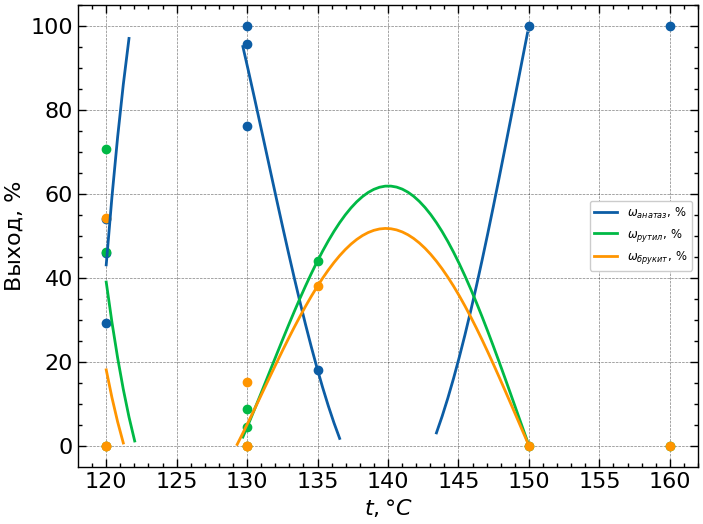

,Номер,температура,концентрация,соотношение,анатаз,рутил,брукит,окр_анатаз,окр_рутил,окр_брукит,...,пгс_масса,мокрый_масса,сухой_масса,после_прокалки_%,агрегаты_размер,насыпной_вес,время_выдержки,пгс_плотность,область_концентраций,объем_реактора
23,102,120,21.00,0.100,45.9,0.0,54.1,7.5,NaN,NaN,...,37.38,22.25,7.56,NaN,NaN,NaN,NaN,1.132727,высокая,малый
31,111,120,21.50,0.100,53.9,46.1,0.0,9.9,7.3,NaN,...,37.74,25.41,7.74,NaN,NaN,NaN,NaN,1.078286,высокая,малый
38,118,120,21.50,0.109,29.3,70.7,0.0,7.9,11.7,NaN,...,75.46,34.61,12.00,NaN,NaN,NaN,NaN,1.217097,высокая,малый
33,113,130,21.50,0.100,100.0,0.0,0.0,7.2,NaN,NaN,...,47.46,34.38,12.69,NaN,NaN,NaN,NaN,1.157561,высокая,малый
34,114,130,21.50,0.100,95.5,4.5,0.0,8.7,10.5,NaN,...,68.20,47.12,19.91,NaN,NaN,NaN,NaN,1.165812,высокая,NaN
36,116,130,21.50,0.100,76.2,8.7,15.1,8.8,10.2,6.8,...,NaN,53.02,23.44,NaN,NaN,NaN,NaN,NaN,высокая,NaN
0,70,135,21.32,0.116,18.0,44.0,38.0,8.2,24.2,17.2,...,NaN,NaN,NaN,NaN,5.62,0.596,NaN,NaN,высокая,NaN
28,107,150,21.50,0.100,100.0,0.0,0.0,7.3,NaN,NaN,...,NaN,33.87,8.50,NaN,NaN,NaN,NaN,NaN,высокая,малый
14,85,160,21.50,0.100,100.0,0.0,0.0,8.3,NaN,NaN,...,47.90,55.21,16.55,92.37,1.51,0.492,NaN,1.212658,высокая,стандартный


In [11]:
def cut_fit_errors(y):
    return list(map(lambda x: x if 0<x<100 else np.nan, y))

ratio_filter = (df['соотношение'] <= 0.12) & (df['соотношение'] >= 0.10)
concentration_filter = df['область_концентраций'] == 'высокая'

x = df[ratio_filter & concentration_filter].sort_values(by='температура')['температура'].values
anatase = df[ratio_filter & concentration_filter].sort_values(by='температура')['анатаз'].values
rutile = df[ratio_filter & concentration_filter].sort_values(by='температура')['рутил'].values
brukite = df[ratio_filter & concentration_filter].sort_values(by='температура')['брукит'].values

x_ = np.linspace(min(x), max(x), 100)
x_brukite = np.linspace(120, 160, 100)

N_ANATASE =4
N_RUTILE = 4
N_BRUKITE =4
y_anatase = np.polyfit(x,anatase,N_ANATASE)
y_rutile = np.polyfit(x,rutile,N_RUTILE)
y_brukite = np.polyfit(x,brukite,N_BRUKITE)


plt.plot(x_,cut_fit_errors(np.polyval(y_anatase,x_)), label='$\omega_{анатаз},\:\%$')
plt.scatter(x,anatase)
plt.plot(x_,cut_fit_errors(np.polyval(y_rutile,x_)), label='$\omega_{рутил},\:\%$')
plt.scatter(x,rutile)
plt.plot(x_brukite,cut_fit_errors(np.polyval(y_brukite,x_brukite)), label='$\omega_{брукит},\:\%$')
plt.scatter(x,brukite)


plt.legend(loc='best', fontsize='small')
plt.ylabel("Выход, %")
plt.xlabel(r'$ t,°C $')

print(f'Адекватность линий тренда {np.mean([(np.polyval(y_anatase,x)+np.polyval(y_rutile,x)+np.polyval(y_brukite,x))/100 for x in x_])}')
plt.show()
df[ratio_filter & concentration_filter].sort_values(by='температура')

Адекватность линий тренда 1.000394753524373


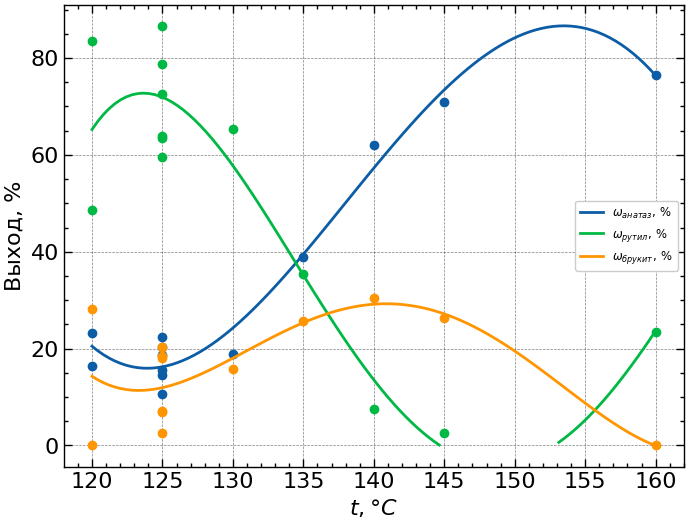

,Номер,температура,концентрация,соотношение,анатаз,рутил,брукит,окр_анатаз,окр_рутил,окр_брукит,...,пгс_масса,мокрый_масса,сухой_масса,после_прокалки_%,агрегаты_размер,насыпной_вес,время_выдержки,пгс_плотность,область_концентраций,объем_реактора
46,126,120,15.1,0.1,16.4,83.6,0.0,8.0,16.8,NaN,...,103.62,36.26,15.59,NaN,NaN,NaN,NaN,1.102340,средняя,стандартный
71,152,120,15.3,0.1,23.3,48.6,28.1,7.0,16.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,средняя,стандартный
47,127,125,15.1,0.1,10.7,86.7,2.6,8.1,16.6,10.5,...,101.40,29.00,14.91,NaN,NaN,NaN,NaN,1.102174,средняя,стандартный
67,147,125,15.3,0.1,14.6,78.7,6.9,7.0,14.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,средняя,стандартный
68,148,125,15.3,0.1,20.3,72.5,7.1,7.0,14.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,90.0,NaN,средняя,стандартный
69,149,125,15.3,0.1,22.4,59.6,18.5,7.5,17.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,260.0,NaN,средняя,стандартный
70,150,125,15.3,0.1,15.6,64.0,20.3,9.5,20.3,10.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,средняя,стандартный
72,153,125,15.3,0.1,18.6,63.4,18.0,7.0,17.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,средняя,стандартный
48,128,130,15.1,0.1,18.9,65.3,15.8,6.5,16.8,10.6,...,95.75,32.50,17.50,NaN,NaN,NaN,NaN,1.113372,средняя,стандартный
25,104,135,14.2,0.1,73.1,12.1,14.8,7.7,12.2,9.2,...,87.34,30.76,14.42,NaN,NaN,NaN,NaN,1.105570,средняя,малый


In [12]:
ratio_filter = (df['соотношение'] <= 0.12) & (df['соотношение'] >= 0.10)
concentration_filter = df['область_концентраций'] == 'средняя'


x = df[ratio_filter & concentration_filter].sort_values(by='температура').drop(25)['температура'].values
anatase = df[ratio_filter & concentration_filter].sort_values(by='температура').drop(25)['анатаз'].values
rutile = df[ratio_filter & concentration_filter].sort_values(by='температура').drop(25)['рутил'].values
brukite = df[ratio_filter & concentration_filter].sort_values(by='температура').drop(25)['брукит'].values

x_ = np.linspace(min(x), max(x), 100)
x_brukite = np.linspace(120, 160, 100)

N_ANATASE = 4
N_RUTILE = 4
N_BRUKITE = 4
y_anatase = np.polyfit(x,anatase,N_ANATASE)
y_rutile = np.polyfit(x,rutile,N_RUTILE)
y_brukite = np.polyfit(x,brukite,N_BRUKITE)


plt.plot(x_,np.polyval(y_anatase,x_), label='$\omega_{анатаз},\:\%$')
plt.scatter(x,anatase)
plt.plot(x_,cut_fit_errors(np.polyval(y_rutile,x_)), label='$\omega_{рутил},\:\%$')
plt.scatter(x,rutile)
plt.plot(x_brukite,np.polyval(y_brukite,x_brukite), label='$\omega_{брукит},\:\%$')
plt.scatter(x,brukite)

plt.legend(loc='best', fontsize='small')
plt.ylabel("Выход, %")
plt.xlabel(r'$ t,°C $')

print(f'Адекватность линий тренда {np.mean([(np.polyval(y_anatase,x)+np.polyval(y_rutile,x)+np.polyval(y_brukite,x))/100 for x in x_])}')
plt.show()
df[ratio_filter & concentration_filter].sort_values(by='температура')

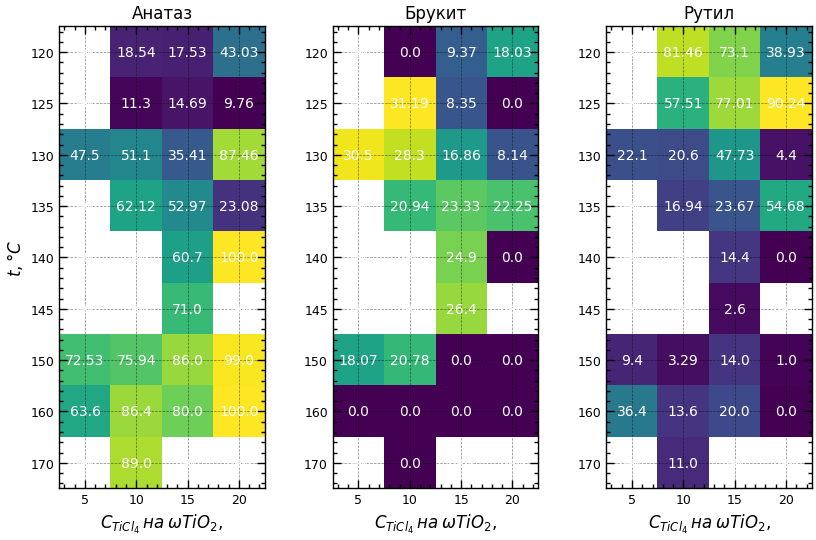

In [13]:
fig = plot.figure_2(df)
#plt.savefig('images/figure_2')

На тепловой карте выше показана зависимость выхода различных фаз от температуры и концентрации.

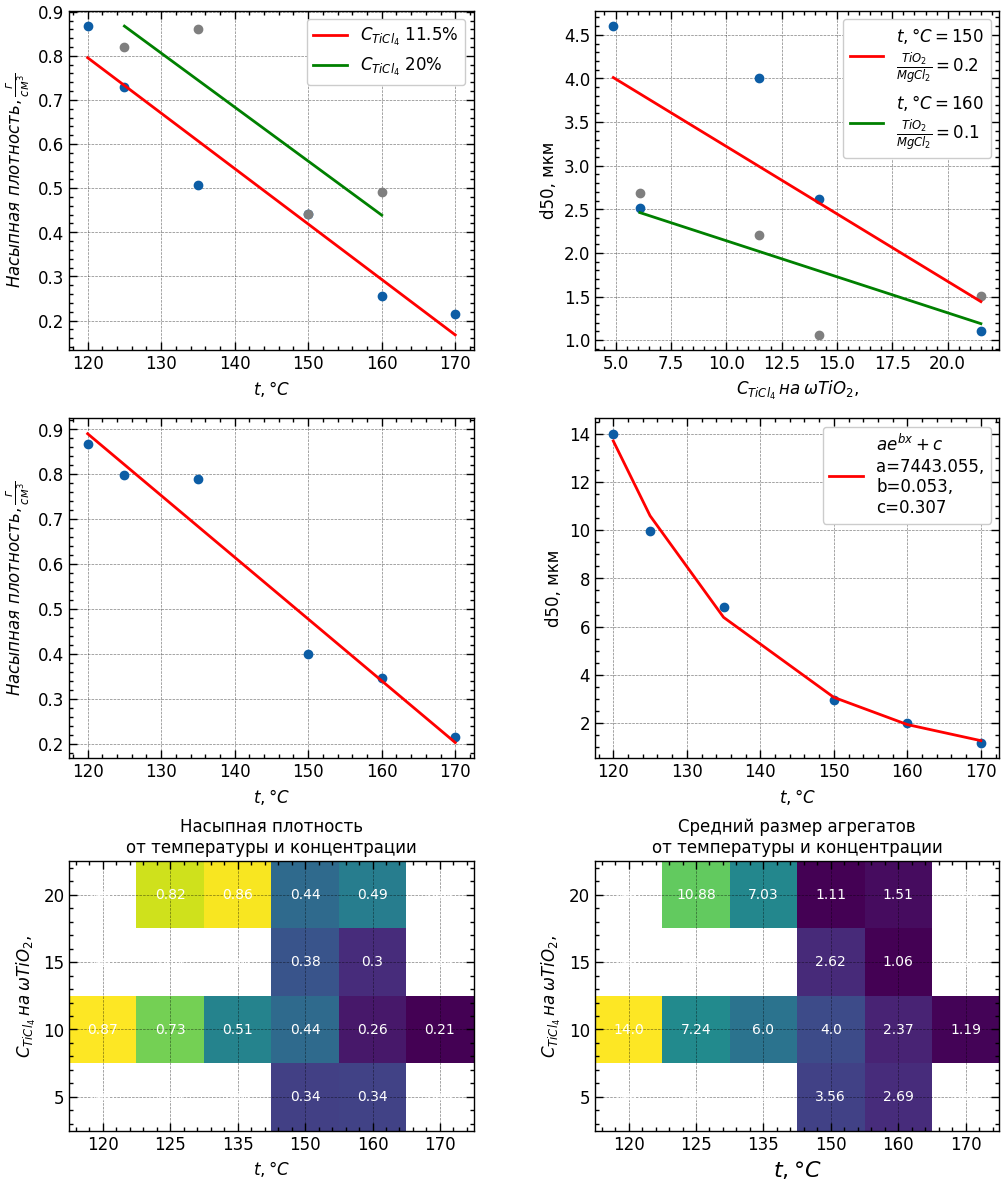

In [14]:
fig = plot.figure_3(df)
#plt.savefig('images/figure_3')

Первые два рисунка показывают зависимость насыпной плотности и среднего размера агрегатов при разных условиях. 

Третий и четвертый график показывают те же зависимости, но с усредненными по температурам значениями

Интересно то, что и насыпная плотность и средний размер агрегатов с температурой уменьшаются. Из общих соображений ожидается, что чем меньше частицы, тем более плотно они могут запонить объем. Так получается из-за того что средний размер агрегатов изучался в приборе, который требует помещение пробы в растовритель. Слабые силы агрегатов разрушаются и мы видим лишь конечный размер частиц. 

In [15]:
us = pd.read_excel('data/ultrasonic_salt_hydrolysis.xlsx')
us['температура'] = us['номер_пробы'].apply(lambda number: int(df[df['Номер'] == number]['температура'].values))
us['концентрация'] = us['номер_пробы'].apply(lambda number: int(df[df['Номер'] == number]['концентрация'].values))
us.head(9)

,номер_пробы,без_уз,уз,время_уз,размер,температура,концентрация
0,110,11.38,63.92,3,0-3,160,11
1,110,5.73,14.83,3,3-6,160,11
2,110,3.26,5.35,3,6-9,160,11
3,110,14.76,6.91,3,9-30,160,11
4,110,8.60,0.79,3,30-60,160,11
5,110,5.46,0.00,3,60-90,160,11
6,110,35.21,7.35,3,90-300,160,11
7,110,15.59,0.85,3,300-600,160,11
8,107,3.62,60.28,3,0-3,150,21


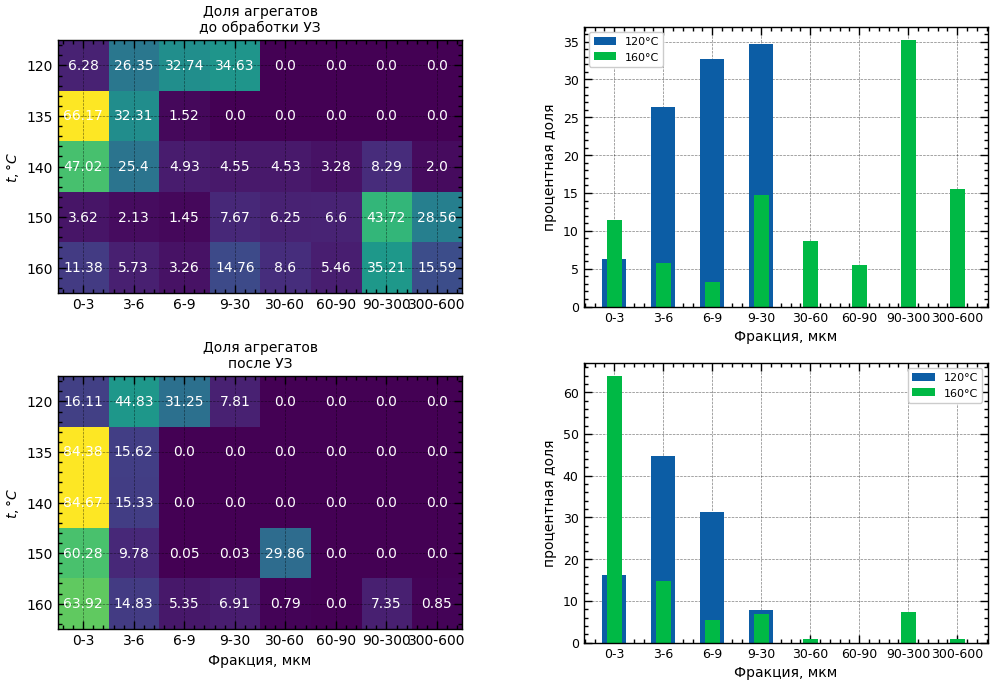

In [16]:
fig = plot.figure_4(us)
#plt.savefig('images/figure_4')

Для проверки этой гипотезы было отобрано несколько проб, синтезированных при разных температурах. 

С целью установления силы межмолекулярных взаимодействий частиц исследовали гранулометрический состав до обработки пробы ультразвуком и после обработки в течение 3-15 минут. На тепловых картах видно, что образцы титанового прекурсора, синтезированного в области высоких температур, имеют более широкое распределение агрегатов по размерам. При этом в обоих образцах присутствует большое количество крупнодисперсной фракции размером >90 мкм, которая не полностью поддается разрушению ультразвуком. Оптимальное время обработки ультразвуком образцов, синтезированных в области высоких температур, составляет 3 минуты. 

Образцы титанового прекурсора, синтезированные в области низких температур процесса солевого гидролиза, имеют самое узкое распределение частиц по размерам, образуя единую фракцию в интервале дисперсности 0-30 мкм. Агрегаты в этих образцах плохо поддаются разбиванию ультразвуком, практически не меняя средний размер даже после 15 минут обработки.

Сопоставление гранулограмм образцов титанового прекурсора показывает, что с увеличением температуры процесса солевого гидролиза распределение частиц по размерам расширяется. 


,окр_анатаз,окр_брукит,окр_рутил
count,72.000000,38.000000,61.000000
mean,7.949306,11.134211,15.468852
std,1.134711,2.915409,3.551316
min,6.500000,6.800000,7.300000
25%,7.100000,10.000000,12.200000
50%,7.800000,11.000000,16.000000
75%,8.350000,11.000000,17.000000
max,14.000000,21.500000,24.200000


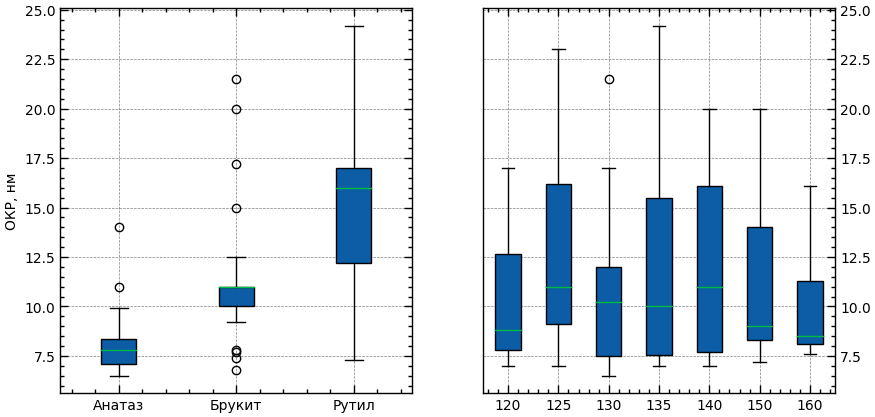

In [17]:
fig, (ax,ax2) = plt.subplots(1,2, figsize=(10,5))
bxplot_data = [df['окр_анатаз'].dropna().values, df['окр_брукит'].dropna().values, df['окр_рутил'].dropna().values]
ax.boxplot(bxplot_data,patch_artist=True,labels=['Анатаз','Брукит','Рутил'])
ax.set_ylabel('ОКР, нм', fontdict={'size':10})
ax.tick_params(axis='both', which='major', labelsize=10)

t = df['температура'].value_counts()[df['температура'].value_counts() > 4].index.sort_values()

CSR_t = [np.array(
    list(df['окр_анатаз'][df['температура'] == t_].dropna().values)
    +list(df['окр_рутил'][df['температура'] == t_].dropna().values)
    +list(df['окр_брукит'][df['температура'] == t_].dropna().values))
         for t_ in t]

ax2.boxplot(CSR_t,labels=t,patch_artist=True)
ax2.yaxis.tick_right()
ax2.tick_params(axis='both', which='major', labelsize=10)
#plt.savefig('images/figure_5')
df[['окр_анатаз','окр_брукит','окр_рутил']].describe()

На первом рисунке сверху показан размер кристаллитов фаз. Примечательно то, что фаза анатаза во всех экспериментах меньше чем фаза брукита(если она образуется), а та в свою очередь меньше фазы рутила. 

На втором рисунке показан размер кристаллитов всех фаз, полученных при определенных температурах. Видно, что ширина распределения кристаллитов по размерам сужается в области высоких температур, а так же имеет локальный минимум в области 130°С.

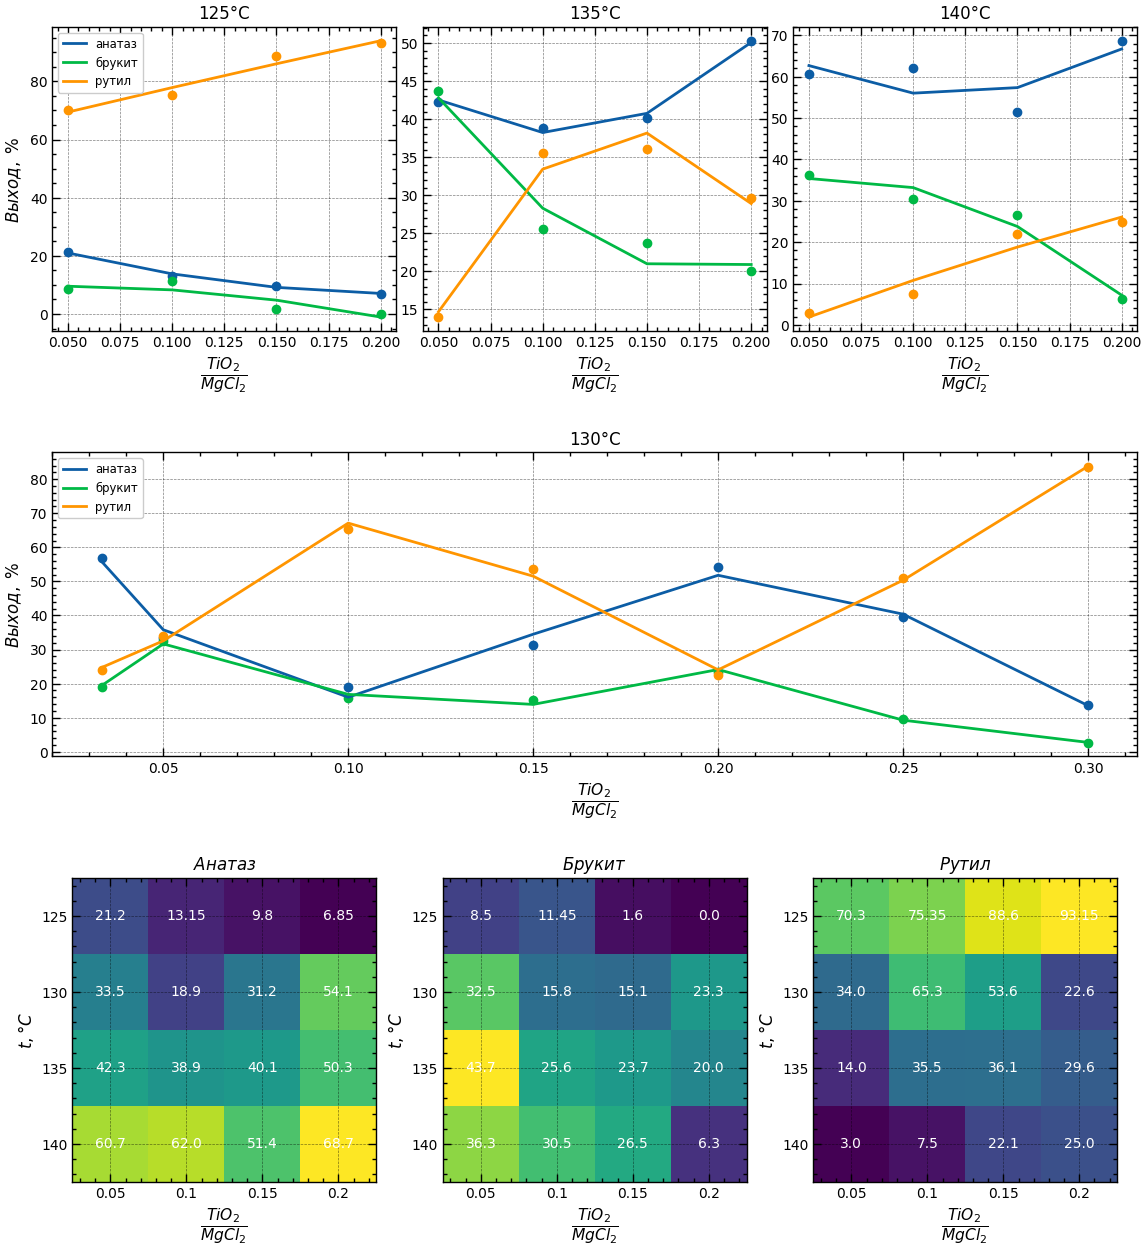

In [18]:
fig = plot.figure_6(df)
#plt.savefig('images/figure_6')

На рисунках выше показана серия экспериментов с одним и тем же раствором концентрации ~15% при различных температурных условиях. Читать графики можно следующим образом: 

при соотношении 0.05 в раствор подали X миллилитров TiCl4, при 0.1 2*X, при 0.15 3*Х, при 0.2 4*Х. Не смотря на то что каждая следующая точка  прошла через концентрацию предыдущей, нелья говорить что в растворе концентрации прекурсоров фаз проходили те же преобразования, так как для того чтобы узнать состав фаз эксперимент прекращали, осадок отфильтровывали, сушили и только потом проводили анализ на состав. 

При 130°С можно наблюдать инверсные корреляции фаз анатаза и рутила. Этот график натолкнул на гипотезу об изоморфном превращении прекурсоров в растворе, о которой речь пойдет ниже.

,5,10,15,20
температура,,,,
120,1.935271,NaN,1.191425,2.036745
125,NaN,NaN,0.927367,NaN
130,1.259332,1.624521,0.999966,1.614891
135,NaN,NaN,1.215321,NaN
140,NaN,NaN,1.152643,0.827749
145,NaN,NaN,1.076591,NaN
150,NaN,1.128347,1.553629,2.307775
160,2.189688,1.855330,1.586847,2.335952


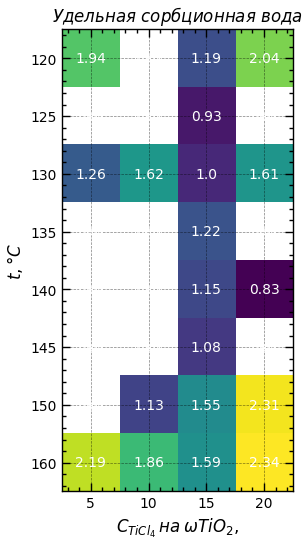

In [19]:
df['удельная_сорбционная_вода'] = (df['мокрый_масса'] - df['сухой_масса'])/df['сухой_масса']

df1 = df.groupby(['температура','область_концентраций'])['удельная_сорбционная_вода'].mean().unstack(
    'область_концентраций')[['малая','минимальная','средняя','высокая']].drop([142,170])
df1.columns=[5,10,15,20]
ax = plt.gca()
im = ax.imshow(df1.values)
ax.set_xticks(np.arange(len(df1.columns)), labels=df1.columns)
ax.set_yticks(np.arange(len(df1.index)), labels=df1.index)

for i in range(df1.values.shape[0]):
    for j in range(df1.values.shape[1]):
        text = ax.text(j, i, np.round(df1.values[i, j], 2),
                       ha="center", va="center", color="w")
        
ax.set_ylabel(r'$ t,°C $', fontdict={'size':12})
ax.set_title('$ Удельная~сорбционная~вода $', fontdict={'size':12})
ax.set_xlabel('$ C_{TiCl_{4}} \: на \: \omega TiO_{2},% $', fontdict={'size':12})
ax.tick_params(axis='both', which='major', labelsize=10)
#plt.savefig('images/figure_7')
df1

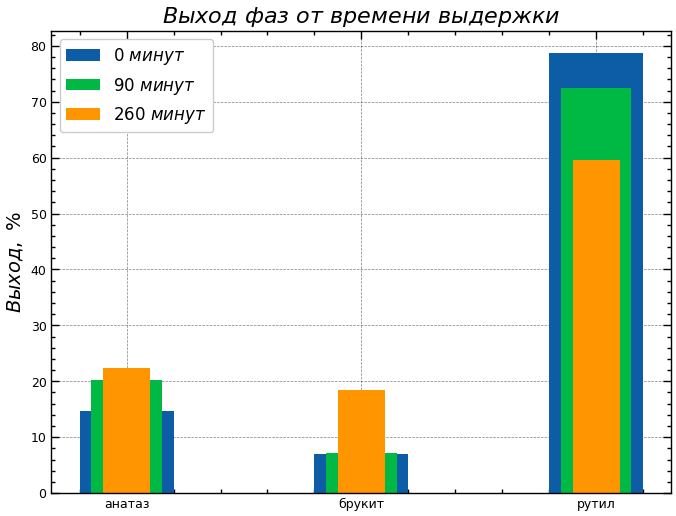

In [20]:
df_ = df[df['время_выдержки'].notna()][['время_выдержки','анатаз','брукит','рутил']]

df1 = df_.groupby('время_выдержки').mean()
h0 = df1.loc[0]
h90 = df1.loc[90]
h260 = df1.loc[260]

p1 = plt.bar(h0.index, h0.values,width=0.4, linewidth=0)
p2 = plt.bar(h90.index, h90.values,width=0.3, linewidth=0)
p3 = plt.bar(h260.index, h260.values,width=0.2, linewidth=0)
ax = plt.gca()
ax.legend((p1[0], p2[0],p3[0]), ('$0~минут$', '$90~минут$','$260~минут$'), prop={'size':12})
ax.set_ylabel('$Выход,~\%$', fontdict={'fontsize':14})
ax.tick_params(axis='both', which='major', labelsize=9)
ax.set_title('$Выход~фаз~от~времени~выдержки$')
#plt.savefig('images/figure_8')
plt.show()

Для проверки гипотезы изоморфмного превращения прекурсоров в растворе был поставлен эксперимент, в котором оксид титана, полученный при определенных условиях, выдерживался в этих условиях 90 и 260 минут. Результаты на рисунке выше.

In [ ]:
def exp_f(x, a, b, c):
    return a * np.exp(b * x) + c

# fig, (ax,ax2) = plt.subplots(1,2,figsize=(10,5))

# x = np.linspace(0,50,100)
# rut, = ax.plot([],[])
# br, = ax.plot([],[])
# an, = ax.plot([],[])
# rut2, = ax2.plot([],[])
# br2, = ax2.plot([],[])
# an2, = ax2.plot([],[])

# B_text = ax.text(0.5, 0.8, '', fontdict={'size':15}, transform=ax.transAxes)
# A_text = ax2.text(1.6, 0.8, '', fontdict={'size':15}, transform=ax.transAxes)

# ax.set_xlim(0,50)
# ax.set_ylim(0,1)
# ax2.set_xlim(0,50)
# ax2.set_ylim(0,1)

# def model_Bf(x,B):
#     rut = exp_f(x,1,-0.1,0)
#     br = exp_f(x,1-rut, -0.1*B,0)
#     an = 1 - rut - br
#     return rut, br, an

# def model_Af(x,A):
#     rut = exp_f(x,1,-A,0)
#     br = exp_f(x,1-rut, -A*0.5,0)
#     an = 1 - rut - br
#     return rut, br, an

# def animate(i):
#     rut.set_data(x,model_Bf(x, 1/50*i)[0])
#     br.set_data(x,model_Bf(x, 1/50*i)[1])
#     an.set_data(x,model_Bf(x, 1/50*i)[2])
#     # ax.set_title(f'A=0.1;B={i/50}')
#     ax.set_xlabel('$Относительная~температура$')
#     ax.set_ylabel('$ Выход,~\% $')
#     rut2.set_data(x,model_Af(x, 1/600*i)[0])
#     br2.set_data(x,model_Af(x, 1/600*i)[1])
#     an2.set_data(x,model_Af(x, 1/600*i)[2])
#     # ax2.set_title(f'A={i/400};B=0.5')
#     ax2.set_xlabel('$Относительная~температура$')
#     ax2.set_ylabel('$ Выход,~\% $')
#     B_text.set_text('A=1;B={:.2f}'.format(i/50))
#     A_text.set_text('A={:.2f};B=0.5'.format(i*10/600))
    
# ani = animation.FuncAnimation(fig, animate, frames=240, interval=50)
# ani.save('images/figure_9.gif',writer='pillow',fps=50)


Исходя из экспериментальных данных, была выдвинута гипотеза о последовательном изоморфном превращении прекурсоров оксида титана. 
$$
\text{Rutile} \xrightarrow{\gamma_1(t)} \text{Brukite} \xrightarrow{\gamma_2(t)} \text{Anatase}
$$
Введем коэффициент пропорциональности $ \gamma $, который будет ответственен за изменение концентрации компонента от точки t до t+1, тогда:
$$
\frac{dRut}{dt}=-\gamma_1 Rut
$$
$$
\frac{dBr}{dt}=\gamma_1 Rut-\gamma_2 Br
$$
$$
\frac{dAn}{dt}=\gamma_2 Br
$$
Откуда можно найти концентрации каждого из компонентов в точке $t$ зная начальное значение $ Rut $:
$$
Rut = Rut_{0}e^{-\gamma_{1}t}
$$
$$
Br = \frac{Rut_{0}(1 - e^{-\gamma_{1}t})}{\gamma_{1}} \cdot (1 - e^{-\gamma_{2}(t - t_{1})})
$$
$$
An = \frac{Rut_{0}(1 - e^{-\gamma_{1}t})}{\gamma_{1}} \cdot e^{-\gamma_{2}(t - t_{1})}
$$
### Откройте гиф-анимацию figure_9 из папки images 
Мы не можем узнать абсолютные значения $ \gamma $, но мы можем выразить их через стандартное состояние. За изменение концентрации рутила отвечает $ \gamma_{1} $.Выберем стандартным состоянием такую систему, при которой концентрация рутила меняется от 1 при 120°С до 0.01 при 170°С. Введем ещё два коэффициента пропорциональности, которые будут показывать насколько система отличается от стандартной. 
$$
A = \frac{\gamma_{1}}{\gamma_{st}}
$$ 
$$
B = \frac{\gamma_{2}}{\gamma_{1}}
$$ 
Далее мы будем приводить любую систему к стандартному состоянию, а той величине что отличает систему от стандартного состояния приписывать значение А. Удобство этой модели заключается в том, что нам необходимо найти только концентрацию рутила от температуры.

На гиф-анимации показано как будет вести себя система в зависимости от того какие значение принимают А и B.

,Номер,температура,концентрация,соотношение,анатаз,рутил,брукит,окр_анатаз,окр_рутил,окр_брукит,...,мокрый_масса,сухой_масса,после_прокалки_%,агрегаты_размер,насыпной_вес,время_выдержки,пгс_плотность,область_концентраций,объем_реактора,удельная_сорбционная_вода
46,126,120,15.1,0.1,16.4,83.6,0.0,8.0,16.8,NaN,...,36.26,15.59,NaN,NaN,NaN,NaN,1.102340,средняя,стандартный,1.325850
71,152,120,15.3,0.1,23.3,48.6,28.1,7.0,16.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,средняя,стандартный,NaN
47,127,125,15.1,0.1,10.7,86.7,2.6,8.1,16.6,10.5,...,29.00,14.91,NaN,NaN,NaN,NaN,1.102174,средняя,стандартный,0.945003
67,147,125,15.3,0.1,14.6,78.7,6.9,7.0,14.0,11.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,средняя,стандартный,NaN
68,148,125,15.3,0.1,20.3,72.5,7.1,7.0,14.0,11.0,...,NaN,NaN,NaN,NaN,NaN,90.0,NaN,средняя,стандартный,NaN
69,149,125,15.3,0.1,22.4,59.6,18.5,7.5,17.0,10.0,...,NaN,NaN,NaN,NaN,NaN,260.0,NaN,средняя,стандартный,NaN
70,150,125,15.3,0.1,15.6,64.0,20.3,9.5,20.3,10.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,средняя,стандартный,NaN
72,153,125,15.3,0.1,18.6,63.4,18.0,7.0,17.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,средняя,стандартный,NaN
48,128,130,15.1,0.1,18.9,65.3,15.8,6.5,16.8,10.6,...,32.50,17.50,NaN,NaN,NaN,NaN,1.113372,средняя,стандартный,0.857143
25,104,135,14.2,0.1,73.1,12.1,14.8,7.7,12.2,9.2,...,30.76,14.42,NaN,NaN,NaN,NaN,1.105570,средняя,малый,1.133148


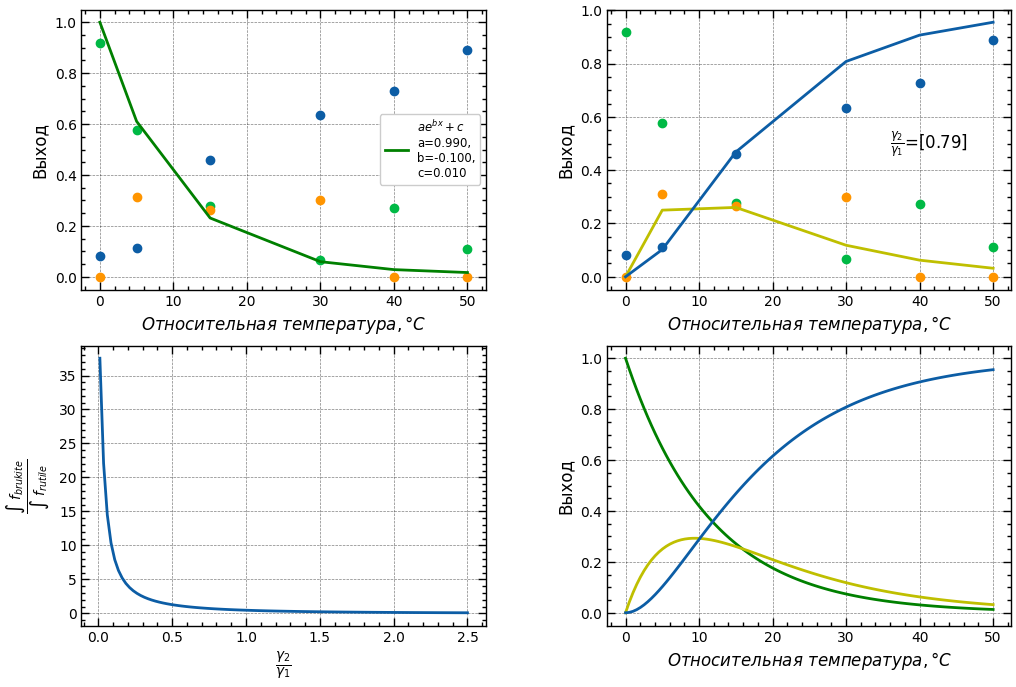

In [22]:
fig = plot.figure_10(df) 
#plt.savefig('images/figure_10')

На рисунке выше показано как можно найти коэффициенты А и В у системы. Коэффициентом А является экспоненциальный множитель b в аппроксимационном уравнении, коэффициент В находят сравнивая отношение интегралов функций брукита и рутила с моделью. На рисунке 3 показаны как относятся интегралы в модели от разных В, на рисунке 4 как выглядят графики функций выхода фаз если в уравнения модели подставить найденые коэффициенты.

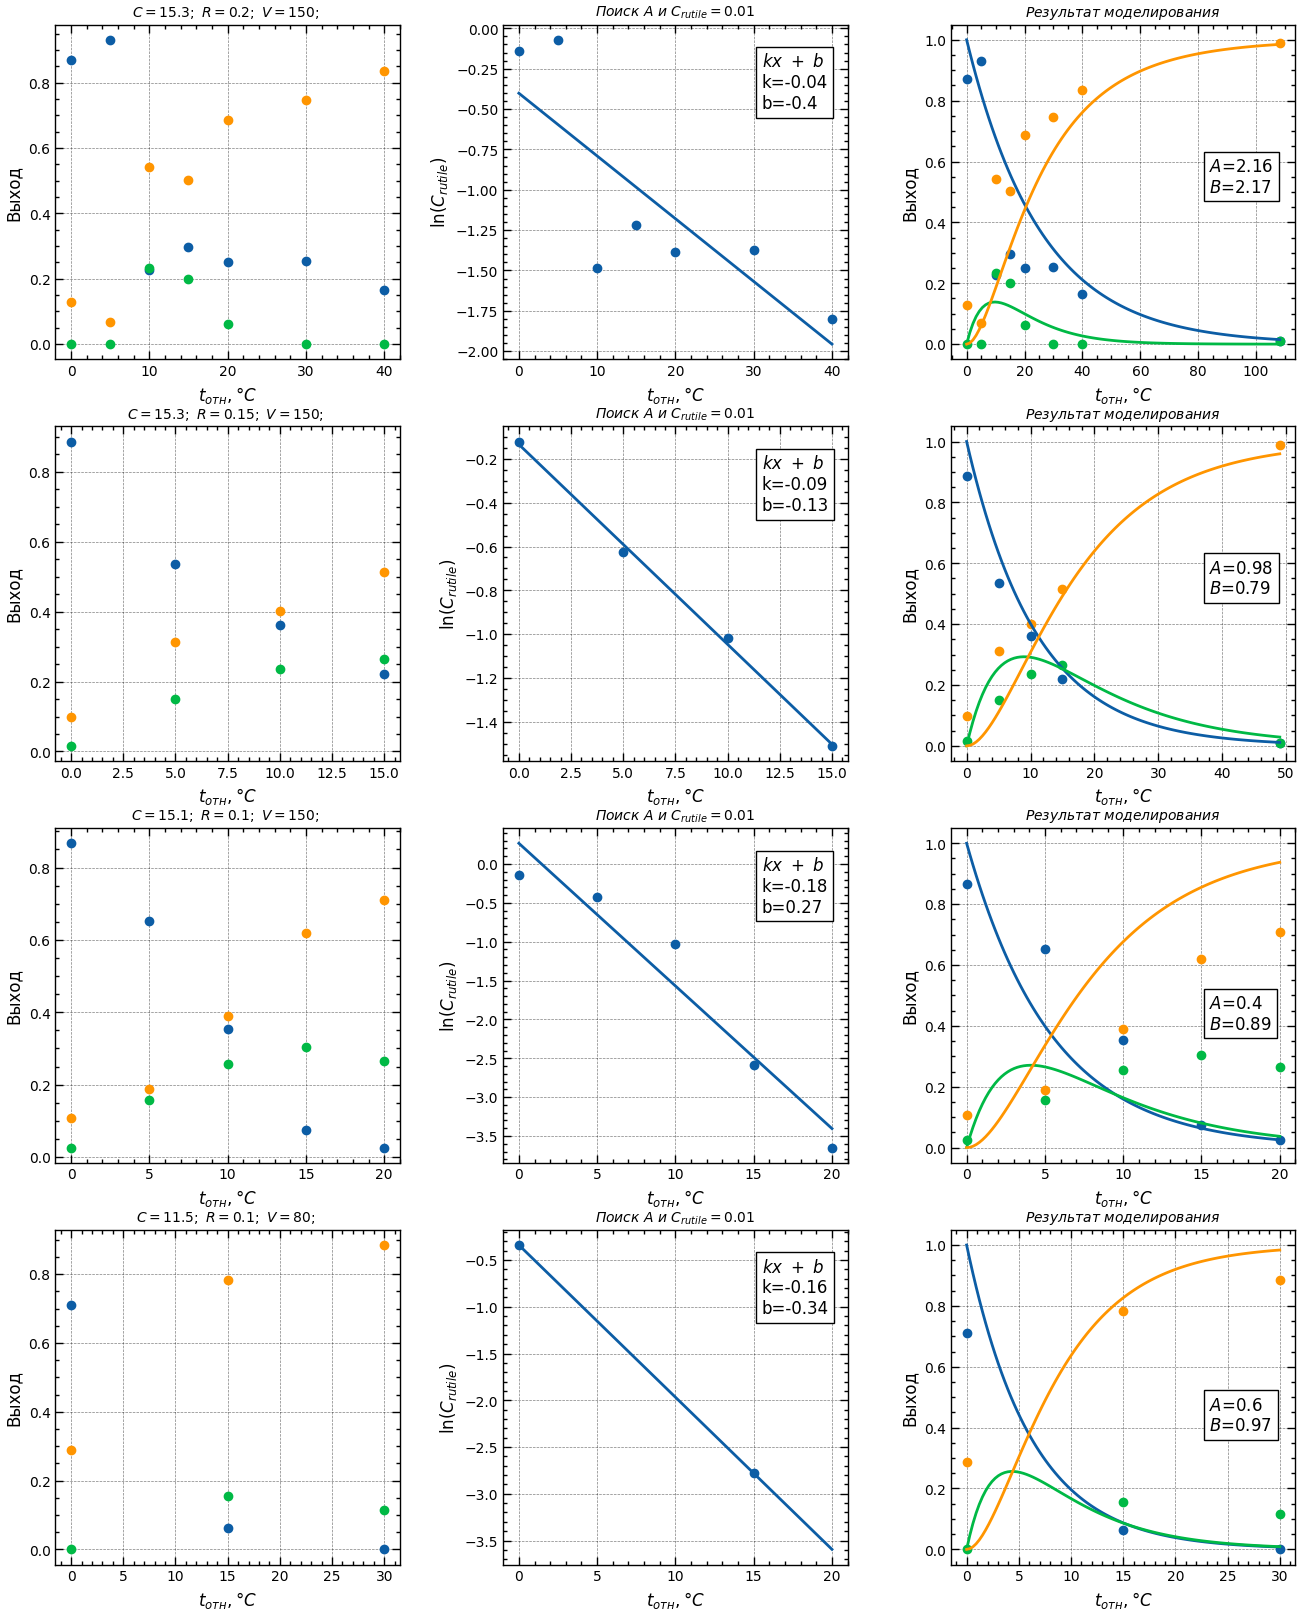

In [23]:
fig = plot.figure_11(df)
#plt.savefig('images/figure_11')

Всего в экспериментальном журнале было найдено 4 системы, в которых совпадают концентрации, соотношения и объемы. На первом рисунке каждого ряда показана сама система, на втором находится коэффиициент А а третий результат моделирования.

Видно что модель неидеальна и требует усовершенствования, однако обладает некоторой предсказательной силой.

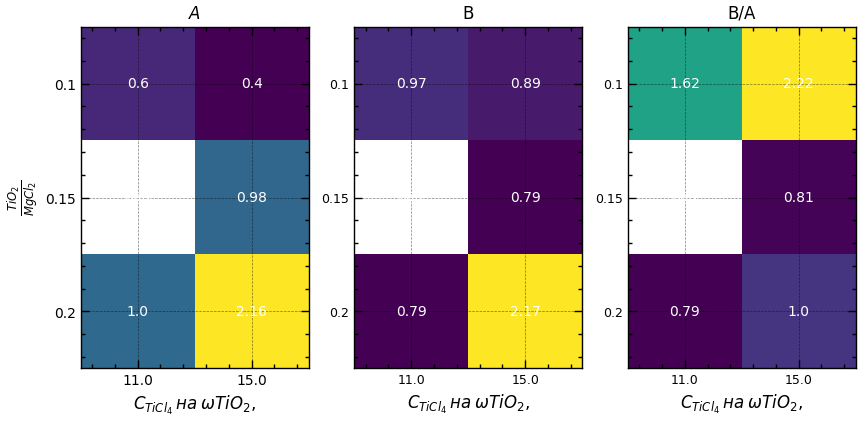

In [24]:

model_results = pd.DataFrame(
    columns=['концентрация','соотношение','объем_реактора','A','_B'],
    data=np.array([
        [11, 0.2, 150, 1, 0.79],
        [11, 0.1, 80, 0.6, 0.97],
        [15, 0.1, 150, 0.4, 0.89],
        [15, 0.15, 150, 0.98, 0.79],
        [15, 0.2, 150, 2.16, 2.17]
        ]),
    )

model_results['B'] = model_results['_B'] / model_results['A']

fig, (ax,ax2,ax3) = plt.subplots(1, 3, figsize=(10, 6))

df1 = model_results.groupby(['соотношение','концентрация'])['A'].mean().unstack('концентрация')

im = ax.imshow(df1.values)
ax.set_xticks(np.arange(len(df1.columns)), labels=df1.columns)
ax.set_yticks(np.arange(len(df1.index)), labels=df1.index)

for i in range(df1.values.shape[0]):
    for j in range(df1.values.shape[1]):
        text = ax.text(j, i, np.round(df1.values[i, j], 2),
                       ha="center", va="center", color="w")
        
ax.set_ylabel('$ \\frac{TiO_{2}}{MgCl_{2}} $', fontdict={'size':12})
ax.set_title('$ А $', fontdict={'size':12})
ax.set_xlabel('$ C_{TiCl_{4}} \: на \: \omega TiO_{2},% $', fontdict={'size':12})
ax.tick_params(axis='both', which='major', labelsize=10)
###
df1 = model_results.groupby(['соотношение','концентрация'])['_B'].mean().unstack('концентрация')
im = ax2.imshow(df1.values)
ax2.set_xticks(np.arange(len(df1.columns)), labels=df1.columns)
ax2.set_yticks(np.arange(len(df1.index)), labels=df1.index)

for i in range(df1.values.shape[0]):
    for j in range(df1.values.shape[1]):
        text = ax2.text(j, i, np.round(df1.values[i, j], 2),
                       ha="center", va="center", color="w")
ax2.set_title('B',fontdict={'size':12})
ax2.set_xlabel('$ C_{TiCl_{4}} \: на \: \omega TiO_{2},% $',fontdict={'size':12})
ax2.tick_params(axis='both', which='major', labelsize=9)
###
df1 = model_results.groupby(['соотношение','концентрация'])['B'].mean().unstack('концентрация')
im = ax3.imshow(df1.values)
ax3.set_xticks(np.arange(len(df1.columns)), labels=df1.columns)
ax3.set_yticks(np.arange(len(df1.index)), labels=df1.index)

for i in range(df1.values.shape[0]):
    for j in range(df1.values.shape[1]):
        text = ax3.text(j, i, np.round(df1.values[i, j], 2),
                       ha="center", va="center", color="w")
ax3.set_title('B/A',fontdict={'size':12})
ax3.set_xlabel('$ C_{TiCl_{4}} \: на \: \omega TiO_{2},% $',fontdict={'size':12})
ax3.tick_params(axis='both', which='major', labelsize=9)
#plt.savefig('images/figure_12')